<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/lecture_13_kernel_density_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kernel density estimation

**K**ernel **D**ensity **E**stimation (KDE) is a technique for estimation of probability distribution of the random variable.
Before we had two instruments for that:
* histograms to capture emphirical frequencies to approximate underlying probability distribution;
* guessing a family of probability distributions that the data probably follows and estimating parameters (using MLE) of a most fit of these distributions.

KDE is another option for us. It can be seen as an extention of the histogram technique.

#Motivating KDE: Histograms

$$
\color{red}{\text{Histograms are trickier than they seem.}}
$$

The bins sizes and location could be chosen in many ways. This can drastically change the overall shape of the histogram.

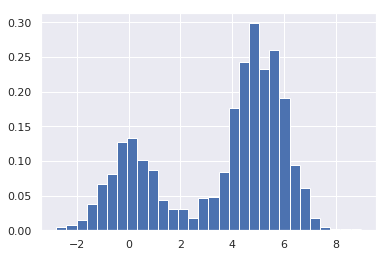

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

def make_data(N, f=0.3, rseed=1):
  rand = np.random.RandomState(rseed)
  x = rand.randn(N)
  x[int(f * N):] += 5
  return x

x = make_data(1000)
hist = plt.hist(x, bins=30, density=True)

In [0]:
# histogram is normed = area equa to 1
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

The issue is that depending on the bins the histograms may have different *qualitive* features. Consider this.

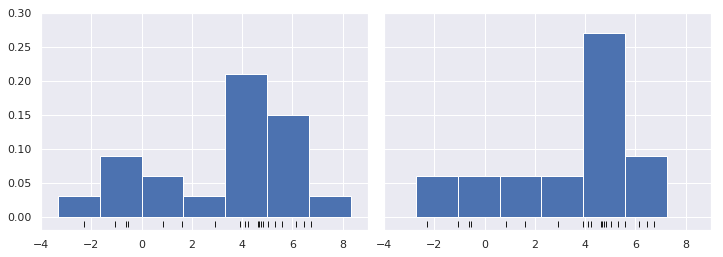

In [0]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True, subplot_kw={'xlim':(-4, 9), 'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
  ax[i].hist(x, bins=bins + offset, density=True)
  ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
  


So it the underlying distribution bimodal or unimodal?

We can try to solve the problem with the ambiguity of the bin choice by the following idea.
You can rethink histogram as square blocks stacked on each other. Each block represents one point of data. If several datapoints are contained within one bin their blocks are placed one at the top of the other.

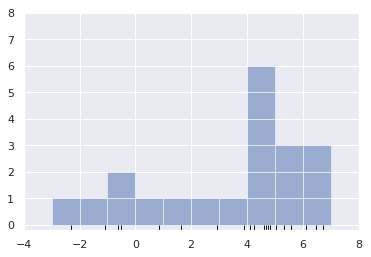

In [0]:
# histogram as blocks
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
  for i in range(count):
    ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha=0.5))
    ax.set_xlim(-4, 8)
    ax.set_ylim(-0.2, 8)

But what if we placed each block so its center is just below the point it represents.

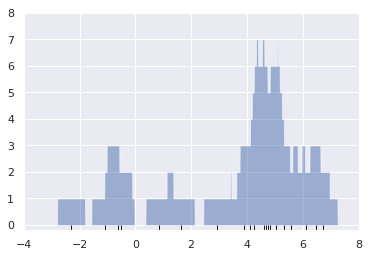

In [0]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 8]);

Analytically this can be seen as if we have placed a "square" function (kernel) centered at each point and then we have summed all the functions up.

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/tophat.png) 

This type of kernel is called top hat as it recalls a flat-crowned hat (aka cylinder).

<br>

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/hat.png) 

<br>

Now to make things not so "squary" we can sum up smooth functions (for example Gaussians) instead of rectangular shapes (top hats).

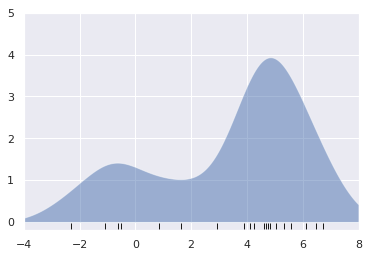

In [0]:
from scipy.stats import norm

x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 5]);

# a Gaussian kernel

#Kernel Density Estimation 

In order to do KDE we need to make our mind about two things:
  * kernel, which specifies the shape of the distribution placed at each point
  * kernel bandwidth, which controls the size of the kernel at each point
    
  [SciKit kernels](https://scikit-learn.org/stable/modules/density.html)

(-0.02, 0.22)

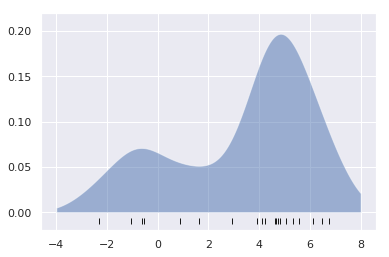

In [0]:
from sklearn.neighbors import KernelDensity
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

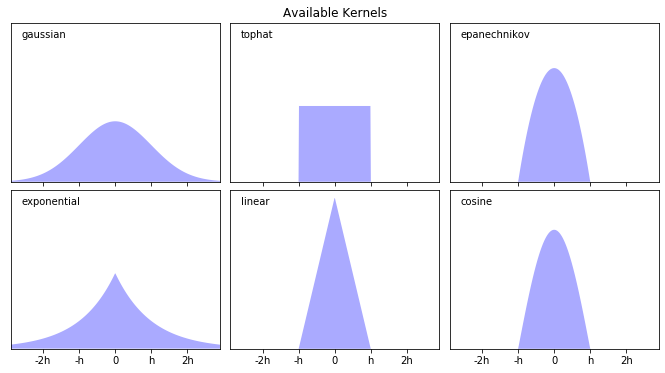

In [0]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity


X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x

for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels');


$$
\begin{aligned}
& K_{\text{Gausian}}(x;h)\propto e^{-\frac{x^2}{2h^2}}, \\
& K_{\text{Tophat}}(x;h)\propto 1 \quad \text{   if   } \quad x<h, \\
& K_{\text{Epanechnikov}}(x;h)\propto 1-\frac{x^2}{h^2}, \\
& K_{\text{Exponential}}(x;h)\propto e^{-\frac{x}{h}}, \\
& K_{\text{Linear}}(x;h)\propto 1-\frac{|x|}{h} \quad \text{   if   } \quad |x|<h, \\
& K_{\text{Cosine}}(x;h)\propto \cos{\frac{\pi x}{2 h}} \quad \text{   if   } \quad x<h. \\
\end{aligned}
$$

you can choose those by setting `kernel` parameter:
* `kernel = 'gaussian';`
* `kernel = 'tophat';`
* `kernel = 'epanechnikov';`
* `kernel = 'exponential';`
* `kernel = 'linear';`
* `kernel = 'cosine'.`

# KDE as Mixture Model

We see that KDE reminds MM taken to the extreme: the number of components we throw into the mix equals the number of points.

<br>

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/mix.png) 

##Selecting the bandwidth via cross-validation

The choice of bandwidth within KDE is extremely important (the bias–variance trade-off).

   *  too narrow a bandwidth leads to a high-variance estimate (i.e., overfitting)
   * too wide a bandwidth leads to a high-bias estimate (i.e., underfitting)

In [0]:
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import LeaveOneOut #train_test_split

bandwidths = 10 ** np.linspace(-1, 1, 100)
loo = LeaveOneOut()
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=loo)
grid.fit(x[:, None]);
grid.best_params_

{'bandwidth': 1.1233240329780276}

#Example: KDE on a Sphere

In [0]:
!sudo apt-get install libgeos-dev
!sudo pip3 install -U git+https://github.com/matplotlib/basemap.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 4 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (157 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: f

In [0]:
from sklearn.datasets import fetch_species_distributions
data = fetch_species_distributions()
# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'], data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro') for d in data.train['species']], dtype='int')

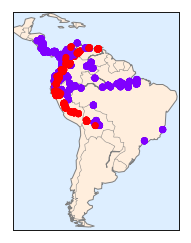

In [0]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids
xgrid, ygrid = construct_grids(data)

# plot coastlines with Basemap
m = Basemap(projection='cyl', resolution='c', llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(), llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3, c=species, cmap='rainbow', latlon=True);

# points overlap, not very informative!
# be careful with such maps!

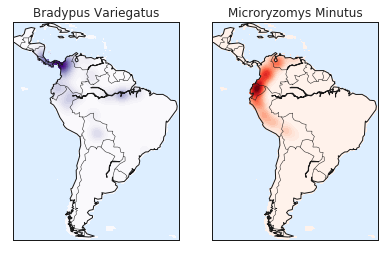

In [0]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
  axi.set_title(species_names[i])

  # plot coastlines with Basemap
  m = Basemap(projection='cyl', llcrnrlat=Y.min(), urcrnrlat=Y.max(), llcrnrlon=X.min(), urcrnrlon=X.max(), resolution='c', ax=axi)
  m.drawmapboundary(fill_color='#DDEEFF')
  m.drawcoastlines()
  m.drawcountries()
  
  # construct a spherical kernel density estimate of the distribution
  kde = KernelDensity(bandwidth=0.03, metric='haversine')
  kde.fit(np.radians(latlon[species == i]))

  # evaluate only on the land: -9999 indicates ocean
  Z = np.full(land_mask.shape[0], -9999.0)
  Z[land_mask] = np.exp(kde.score_samples(xy))
  Z = Z.reshape(X.shape)
  
  # plot contours of the density
  levels = np.linspace(0, Z.max(), 25)
  axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])
  
# a much clearer picture of the geographical distribution of observations of these two species  

#Example: Not-So-Naive Bayes

For naive Bayes, the generative model is a simple axis-aligned Gaussian.
With a density estimation algorithm like KDE, we can remove the “naive” element and perform the same classification with a more sophisticated generative model for each class.
It’s still Bayesian classification, but it’s no longer naive.

1. Split the training data by label.
2. For each set, fit a KDE to obtain a generative model of the data.
This allows you for any observation x and label y to compute a likelihood $P(x|y)$.
3. From the number of examples of each class in the training set, compute the class prior, $P(y)$ .
4. For an unknown point x , the posterior probability for each class is $P(y|x)= P(x|y)P(y)$. The class that maximizes this posterior is the label assigned to the point.

In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity

# BaseEstimator contains the logic necessary to clone/copy an estimator for use in a crossvalidation procedure
# ClassifierMixin defines a default score() method used by such routines
class KDEClassifier(BaseEstimator, ClassifierMixin):
  """Bayesian generative classification based on KDE
  Parameters
  ----------
  bandwidth : float
  the kernel bandwidth within each class
  kernel : str
  the kernel name, passed to KernelDensity
  """
  def __init__(self, bandwidth=1.0, kernel='gaussian'):
    self.bandwidth = bandwidth
    self.kernel = kernel
  
  # find the unique classes in the training data, 
  # train a KernelDensity model for each class, 
  # compute the class priors based on the number of input samples.
  def fit(self, X, y):
    self.classes_ = np.sort(np.unique(y))
    training_sets = [X[y == yi] for yi in self.classes_]
    self.models_ = [KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel).fit(Xi) for Xi in training_sets]
    self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
    return self # for chaining
  
  # predicting labels on new data
  def predict_proba(self, X):
    logprobs = np.array([model.score_samples(X) for model in self.models_]).T
    result = np.exp(logprobs + self.logpriors_)
    return result / result.sum(1, keepdims=True)
  
  def predict(self, X):
    return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [0]:
# use our creature

from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()
bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths}, cv=3)
grid.fit(digits.data, digits.target)
scores = grid.cv_results_['mean_test_score']

{'bandwidth': 7.054802310718643}
accuracy = 0.9666110183639399


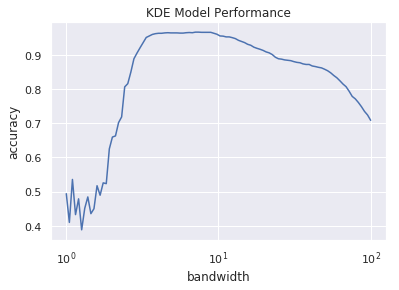

In [0]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

In [0]:
# compare with naive approach

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target, cv=3).mean()

0.8186003803550138

`Seaborn` has a nice feature called `kdeplot` that helps to visualize KDE.

Text(3.8, 4.5, 'setosa')

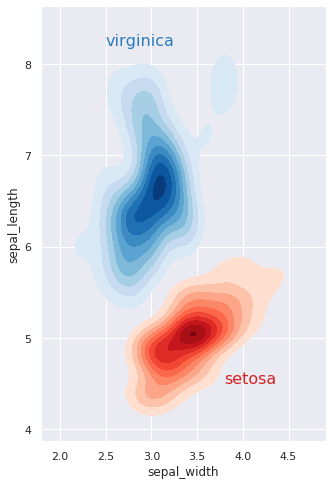

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
iris = sns.load_dataset("iris")

# Subset the iris dataset by species
setosa = iris.query("species == 'setosa'")
virginica = iris.query("species == 'virginica'")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(setosa.sepal_width, setosa.sepal_length,
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(virginica.sepal_width, virginica.sepal_length,
                 cmap="Blues", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(2.5, 8.2, "virginica", size=16, color=blue)
ax.text(3.8, 4.5, "setosa", size=16, color=red)